# Collecting/parsing/utilizing data from SF Bay NOAA buoys

This notebook shows the scraping of NOAA buoy data and the construction of a number of functions to display either real-time or historical data, organized by geography. 

In [1]:
#Import libraries


from datetime import datetime, timedelta
import gzip
import numpy as np
import requests
import urllib
import requests
from urllib.request import Request, urlopen 
import re

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import seaborn
from bs4 import BeautifulSoup
from matplotlib.pyplot import figure



In [31]:
#Set URLs to work with. These can be found by checking the noaa website, which organizes data into different pages
#depending on the type of data. 

_BASEURL = 'http://www.ndbc.noaa.gov/data'
_SENSOR_URL = _BASEURL+'/stations/buoyht.txt'
_REALTIME_URL = _BASEURL+'/realtime2/'
_RECENT_URL = _BASEURL+'/stdmet/'
_HISTORICAL_URL = _BASEURL+'/historical/stdmet/'
_STATION_URL = _BASEURL+'/stations/station_table.txt'

## Build functions to retrieve and parse real-time info from buoys

These functions, with slight modifications, are generally useful. Here, they are used to create lists of url links with specific types of information in them. For example, all ".txt." links contain data on water temperature. Calling this function with different extensions therefore allows for a parallel path to be added to a pipeline.

In [3]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re

_REAL_TIME_DATA_URL = "https://www.ndbc.noaa.gov/data/realtime2"



def get_links_from_lxml(url, ext):
    """
    With starting url and page extensions, parses page and pulls all links with that extension.
    """
    req = Request(url)
    html_page = urlopen(req)
    soup = BeautifulSoup(html_page, "lxml")
    ext_link_list = []
    ext_object_list = []
    links = []
    for link in soup.findAll('a'): 
        links.append(link.get('href'))
    for entry in links:
        if str(ext) in entry:
            ext_link_list.append(entry)
            ext_object_list.append(entry[:-4])
    return ext_link_list, ext_object_list
       
#head(get_links_from_lxml("https://www.ndbc.noaa.gov/data/realtime2", ".txt"))
get_links_df = pd.DataFrame({"links": get_links_from_lxml("https://www.ndbc.noaa.gov/data/realtime2", ".txt")[0], 
                             "buoys": get_links_from_lxml("https://www.ndbc.noaa.gov/data/realtime2", ".txt")[1]})
get_links_df.head()


,links,buoys
0,32ST0.txt,32ST0
1,41NT0.txt,41NT0
2,45T01.txt,45T01
3,46T29.txt,46T29
4,51WH0.txt,51WH0


## Get coordinates for buoys from their URLs

https://www.ndbc.noaa.gov/data/stations/station_table.txt is a list of all buoys controlled by NOAA. This table can be scraped to give latitude and longitude info for each buoy. 

In [4]:
#All buoy coordinates are collected:

def get_all_coordinates(url):
    """
    Generates a pandas data frame of buoy IDs and longitude/latitude values.
    """
    r = requests.get(url)
    lines = r.text.split('\n')
    
    #buoy IDs and coordinates can be split into separate lists:
    buoy_ids = [line.split("|")[0] for line in lines[2:len(lines)-1]]
    coords = [line.split("|")[6].split("(")[0] for line in lines[2:len(lines)-1]]
    
    #Initialize pandas dataframe with buoy ids and coordinates:    
    coordinates_df = pd.DataFrame({"Buoy_IDs" : buoy_ids, "Coords" : coords})
    
    #Use conditional list comprehension to split coordinates into plottable data:
    coordinates_df["latitude"] = [float(t.split()[0]) if t.split()[1] =="N" else -float(t.split()[0]) for t in coordinates_df['Coords']]
    coordinates_df["longitude"] = [float(t.split()[2]) if t.split()[3] == "E" else -float(t.split()[2]) for t in coordinates_df['Coords']]
       
    return coordinates_df
        
get_all_coordinates("https://www.ndbc.noaa.gov/data/stations/station_table.txt").head()

,Buoy_IDs,Coords,latitude,longitude
0,00922,30.000 N 90.000 W,30.0,-90.0
1,00923,30.000 N 90.000 W,30.0,-90.0
2,01500,30.000 N 90.000 W,30.0,-90.0
3,01502,30.000 N 90.000 W,30.0,-90.0
4,01503,30.000 N 90.000 W,30.0,-90.0


### Sanity check

In [13]:
all_coordinates = get_all_coordinates("https://www.ndbc.noaa.gov/data/stations/station_table.txt")
all_coordinates.describe()

,latitude,longitude
count,1817.000000,1817.000000
mean,34.461335,-80.883197
std,15.494737,62.564222
min,-55.000000,-179.903000
25%,27.890000,-117.444000
50%,33.865000,-87.901000
75%,43.762000,-75.739000
max,75.778000,179.012000


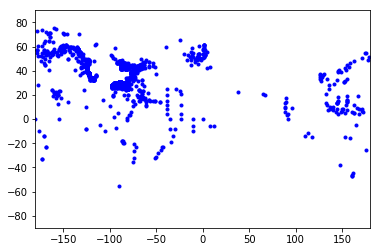

In [5]:
# Plot all buoy coordinates from above

all_coordinates = get_all_coordinates("https://www.ndbc.noaa.gov/data/stations/station_table.txt")

plt.figure()
plt.xlim(-180,180)
plt.ylim(-90,90)
plt.plot(all_coordinates["longitude"], all_coordinates["latitude"], "b.")
plt.show()

## Use gmaps to plot buoys on interactive world map:

In [17]:
import gmaps
import gmaps.datasets
from config import API_KEY
gmaps.configure(api_key=API_KEY)

gmaps_coords = all_coordinates[["latitude", "longitude"]]

gmaps_coords_layer = gmaps.symbol_layer(
    gmaps_coords, fill_color="green", stroke_color="green", scale=2
)
fig = gmaps.figure()
fig.add_layer(gmaps_coords_layer)
fig

Figure(layout=FigureLayout(height='420px'))

## With all coordinates now collected, we can subset based on various attributes.

For example, we may with to only collect buoys for which real-time water-temp data is available. Here, use the subset of buoys with real-time info from our get_links_from_xml().

In [23]:
def get_subset_coordinates(input_list):
    """
    Generates a pandas data frame of buoy IDs and longitude/latitude values for a list of buoy IDs passed in. 
    """
    #get list of all buoys by calling get_all_coordinates():
    full_buoy_df = get_all_coordinates("https://www.ndbc.noaa.gov/data/stations/station_table.txt")
    all_buoys_list = input_list
    buoy_ids = input_list
    input_list_df = pd.DataFrame({"Buoy_IDs" : buoy_ids})
    merged_df = input_list_df.merge(full_buoy_df, left_on="Buoy_IDs", right_on="Buoy_IDs", how="inner")
       
    return merged_df

real_time_subset = get_links_from_lxml("https://www.ndbc.noaa.gov/data/realtime2", ".txt")[1] 

get_subset_coordinates(real_time_subset).head()



314


,Buoy_IDs,Coords,latitude,longitude
0,41002,31.760 N 74.840 W,31.760,-74.840
1,41004,32.501 N 79.099 W,32.501,-79.099
2,41008,31.400 N 80.868 W,31.400,-80.868
3,41009,28.501 N 80.184 W,28.501,-80.184
4,41010,28.878 N 78.485 W,28.878,-78.485


## Plot this buoy subset:

In [22]:
real_time_buoys = get_subset_coordinates(real_time_subset)

gmaps_coords = real_time_buoys[["latitude", "longitude"]]

gmaps_coords_layer = gmaps.symbol_layer(gmaps_coords, fill_color="green", stroke_color="green", scale=2)
fig = gmaps.figure()
fig.add_layer(gmaps_coords_layer)
fig

Figure(layout=FigureLayout(height='420px'))

# Define Class Buoy: includes methods to check current conditions and to build/update pandas dataframes with buoy data

In [46]:
REAL_TIME_URL_BASE = "https://www.ndbc.noaa.gov/data/realtime2"

class Buoy:
    
    
    
    def __init__(self, station_id):
        """
        Buoy Class
        """
        self.station_id = station_id
        
    def link_finder(self):
        ###need to introduce a try/except clause to handle buoys that do not exist
        """
        Finds the real-time data .txt file for a given buoy. This file contains attributes to be called by
        additional buoy methods.
        """
        target = self.station_id
        return REAL_TIME_URL_BASE + "/" + str(target) + ".txt"
    
    def wtmp(self):
        """
        Returns real-time water temp at a given buoy
        """
        r = requests.get(self.link_finder())
        lines = r.text.split('\n')
        for line in lines[2:3]:
            line = line.split()  
            try:
                water_temp = float(line[14])
                return water_temp
            except ValueError:
                return "No Current Value for this Buoy"
    
    def atmp(self):
        """
        Returns real-time air temp at a given buoy
        """
        r = requests.get(self.link_finder())
        lines = r.text.split('\n')
        for line in lines[2:3]:
            line = line.split()   
            try: 
                air_temp = float(line[13])
                return "Current Air Temp for Buoy %s is %s degrees C" % (self.station_id, air_temp)
            except ValueError:
                return "No Current Value for this Buoy"
        
    def real_time_data(self):
        
        """
        Collects air temp, water temp, and time stamp data from a buoy, and appends these values to a .db file
        """
        df = pd.DataFrame()
        r = requests.get(self.link_finder())
        lines = r.text.split('\n')
        year_dat = []
        water_temp = []
        air_temp = []
        tod = []
        dates = []
        for line in lines[2:len(lines)-1]:
            line = line.split()   
            water_temp.append(line[14])
            air_temp.append(line[13])
            tod.append(line[3] + ":" + line[4])
            dates.append(line[0:3])
        return water_temp , tod, dates       

    def df_build(self):
        
        
        df = pd.DataFrame(columns = ["time_stamp", "b%s water_temp (C)" % self.station_id , "air_temp (C)"])
        r = requests.get(self.link_finder())
        lines = r.text.split('\n')
        for i in range(2,len(lines)-2100):
            line = lines[i].split()
            time_stamp = line[0] + "-" + line[1] + "-" + line[2] + " " + line[3] + ":" + line[4]
            df.loc[i] = [time_stamp , line[14] , line[13]]
        return df

## Collect real-time water temp values for our buoys:

In [105]:
#Add a column to our buoy subset to include real-time water temperature:

real_time_buoys["wtmp"] = [Buoy(i).wtmp() for i in real_time_buoys["Buoy_IDs"]]

In [158]:
real_time_buoys.head()
weights = real_time_buoys['wtmp']
real_time_buoys.head(15)
#drop non-numeric rows:
real_time_buoys_cleaned = real_time_buoys[real_time_buoys["wtmp"] != "No Current Value for this Buoy"]
real_time_buoys_cleaned.head()

,Buoy_IDs,Coords,latitude,longitude,wtmp
0,41002,31.760 N 74.840 W,31.760,-74.840,27.1
1,41004,32.501 N 79.099 W,32.501,-79.099,27.5
2,41008,31.400 N 80.868 W,31.400,-80.868,29.5
3,41009,28.501 N 80.184 W,28.501,-80.184,30
4,41010,28.878 N 78.485 W,28.878,-78.485,29.4


## Visualize real-time water temp as a function of location

To do this, use viridis scaling of wtmp (mix-max, then color-relation). Attach viridis values to each location with a water temperature value and plot the results. 

In [166]:
from matplotlib.cm import viridis
from matplotlib.colors import to_hex

In [167]:
real_time_buoys_cleaned.head()

,Buoy_IDs,Coords,latitude,longitude,wtmp
0,41002,31.760 N 74.840 W,31.760,-74.840,27.1
1,41004,32.501 N 79.099 W,32.501,-79.099,27.5
2,41008,31.400 N 80.868 W,31.400,-80.868,29.5
3,41009,28.501 N 80.184 W,28.501,-80.184,30
4,41010,28.878 N 78.485 W,28.878,-78.485,29.4


In [180]:
min_gini = (real_time_buoys_cleaned["wtmp"]).min()
max_gini = (real_time_buoys_cleaned["wtmp"]).max()
gini_range = max_gini - min_gini

#set colors:
def calculate_color(gini):
    """
    Convert the GINI coefficient to a color
    """
    # make gini a number between 0 and 1
    normalized_gini = (gini - min_gini) / gini_range
    # invert gini so that high inequality gives dark color
    inverse_gini = 1.0 - normalized_gini
    # transform the gini coefficient to a matplotlib color
   # mpl_color = viridis(inverse_gini)
    mpl_color = viridis(normalized_gini)
    # transform from a matplotlib color to a valid CSS color
    gmaps_color = to_hex(mpl_color, keep_alpha=False)
    return gmaps_color

In [181]:
colors = []
for t in real_time_buoys_cleaned["wtmp"]:
    color = calculate_color(t)
    colors.append(color)


In [182]:
locations = real_time_buoys_cleaned[['latitude', 'longitude']]
weights = real_time_buoys_cleaned['wtmp']

gmaps_coords = real_time_buoys_cleaned[['latitude', 'longitude']]



gmaps_coords_layer = gmaps.symbol_layer(gmaps_coords, fill_color=colors, stroke_color=colors, scale=2)
fig = gmaps.figure()
fig.add_layer(gmaps_coords_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [ ]:
###generate a sql database from the above:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
df = buoy.df_build()
df.to_sql('buoys', con=engine)
engine.execute("SELECT * FROM buoys").fetchall()

In [ ]:
#using the list of links, collect n links at a time and append data

In [ ]:
#scrape lat/lon coordinates from buoy numbers. Use these coordinates to define a subset of buoys to collect data from
# for example only around sf bay area

In [ ]:
#build arrays, one per time point per buoy

In [ ]:
def get_info(self):
    target_buoy = self
  #  r = requests.get(REAL_TIME_URL_BASE+ "link" + ".txt")
    s = REAL_TIME_URL_BASE+ "/" + str(target_buoy) + ".txt"
    print(s)
get_info(123)

In [ ]:
#directly test whether linear model predicts relationship between water temp at in-bay vs out-of-bay buoys, whether 
#data is cyclical via tide times, etc.